In [1]:
import os
import torch
import torch.cuda
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from proj_utils import *
from collections import OrderedDict
from tqdm import tqdm
%matplotlib inline

# Step 1: 

### Packaging important meta data

In [2]:
DATA_DIR1 = (
    "/media/yoel/second_ssd/neu502b/"
    "sherlock_mv4_png/sherlock_part1_pngs"
)

DATA_DIR2 = (
    "/media/yoel/second_ssd/neu502b/"
    "sherlock_mv4_png/sherlock_part2_pngs"
)

PART1_INFO = {}
PART2_INFO = {}

files1 = [os.path.join(DATA_DIR1, x) for x in os.listdir(DATA_DIR1) if x.endswith(".png")]
files2 = [os.path.join(DATA_DIR2, x) for x in os.listdir(DATA_DIR2) if x.endswith(".png")]

PART1_INFO["nframes"] = len(files1)
PART1_INFO["nmins"] = 23.47
PART1_INFO["nsecs"] = PART1_INFO["nmins"] * 60
PART1_INFO["tr"] = 1.5
PART1_INFO["ntr"] = 946
PART1_INFO["frames_per_sec"] = PART1_INFO["nframes"] / PART1_INFO["nsecs"]
PART1_INFO["frames_per_tr"] = PART1_INFO["frames_per_sec"] * 0.5 + PART1_INFO["frames_per_sec"]

PART2_INFO["nframes"] = len(files2)
PART2_INFO["nmins"] = 25.55
PART2_INFO["nsecs"] = PART2_INFO["nmins"] * 60
PART2_INFO["tr"] = 1.5
PART2_INFO["ntr"] = 1030
PART2_INFO["frames_per_sec"] = PART2_INFO["nframes"] / PART2_INFO["nsecs"]
PART2_INFO["frames_per_tr"] = PART2_INFO["frames_per_sec"] * 0.5 + PART2_INFO["frames_per_sec"]

print("part 1 informatin:\n", PART1_INFO)

print("\npart 2 information:\n", PART2_INFO)

# sort each file list by the frame number
files1 = list(sort_files(files1))
files2 = list(sort_files(files2))

# these should match the nframes so we will assert that
assert int(files1[-1].split("_")[-1].split(".")[0]) == PART1_INFO["nframes"]
assert int(files2[-1].split("_")[-1].split(".")[0]) == PART2_INFO["nframes"]

BATCH_SIZE = 37.5
LAYERS = (1, 4, 7, 9, 11)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

part 1 informatin:
 {'nframes': 35655, 'nmins': 23.47, 'nsecs': 1408.1999999999998, 'tr': 1.5, 'ntr': 946, 'frames_per_sec': 25.319556881124843, 'frames_per_tr': 37.979335321687266}

part 2 information:
 {'nframes': 38870, 'nmins': 25.55, 'nsecs': 1533.0, 'tr': 1.5, 'ntr': 1030, 'frames_per_sec': 25.355512067840834, 'frames_per_tr': 38.03326810176125}
cuda:0


# Step 2: 

### As seen above about 38 frames correspond to a one TR. We want to compute the activations for each relevant layer of alexnet, for each of the 38 frames in the TR. Then we average those activations across the frame dimension.

TODO:

    [x] create a window within each batch to truncate the frames within the TR: reduced autocorrelation
  
    [x] compute average activations using this truncated window
    
    [x] for each part, for each layer, compute the tr x (dim x dim x dim) correlation matrix
  
    [ ] write the saved correlation matrices to file

In [3]:
# this takes ~ 4 minutes
with torch.no_grad():
    alexnet = models.alexnet(pretrained=True).eval().to(device)
    batch_vals = OrderedDict()
    
    #for idx, batch in enumerate(gen_batch(range(PART2_INFO["nframes"]), BATCH_SIZE)):
    for idx, batch in tqdm(enumerate(gen_ranges(BATCH_SIZE, PART1_INFO["ntr"], 27))):   
        batch_vals[f"batch_{idx}"] = {l:0 for l in LAYERS}
        
        # iterating over all 37
        for frame_index in batch:
            img = process_img(files1[frame_index], unsqueeze=True)
            activations = all_acts(img.to(device), alexnet)
            
            # computing mean resursively to save on array space
            for key in activations.keys():
                batch_vals[f"batch_{idx}"][key] += (
                    1/(frame_index+1) * (activations[key] - batch_vals[f"batch_{idx}"][key])
            )
                
        # move arrays from GPU to cpu to wherever it is usually stored (on the heap?)
        for key in activations.keys():
            batch_vals[f"batch_{idx}"][key] = batch_vals[f"batch_{idx}"][key].cpu().detach().numpy()

946it [03:19,  4.73it/s]


In [4]:
# extract the "time series" of activations
layer1_tr_acts = np.vstack([batch_vals["batch_{}".format(i)][1] for i in range(PART1_INFO["ntr"])])
layer4_tr_acts = np.vstack([batch_vals["batch_{}".format(i)][4] for i in range(PART1_INFO["ntr"])])
layer7_tr_acts = np.vstack([batch_vals["batch_{}".format(i)][7] for i in range(PART1_INFO["ntr"])])
layer9_tr_acts = np.vstack([batch_vals["batch_{}".format(i)][9] for i in range(PART1_INFO["ntr"])])
layer11_tr_acts = np.vstack([batch_vals["batch_{}".format(i)][11] for i in range(PART1_INFO["ntr"])])

In [14]:
c1 = correlation_mat(layer1_tr_acts)
c4 = correlation_mat(layer4_tr_acts)
c7 = correlation_mat(layer7_tr_acts)
c9 = correlation_mat(layer9_tr_acts)
c11 = correlation_mat(layer11_tr_acts)

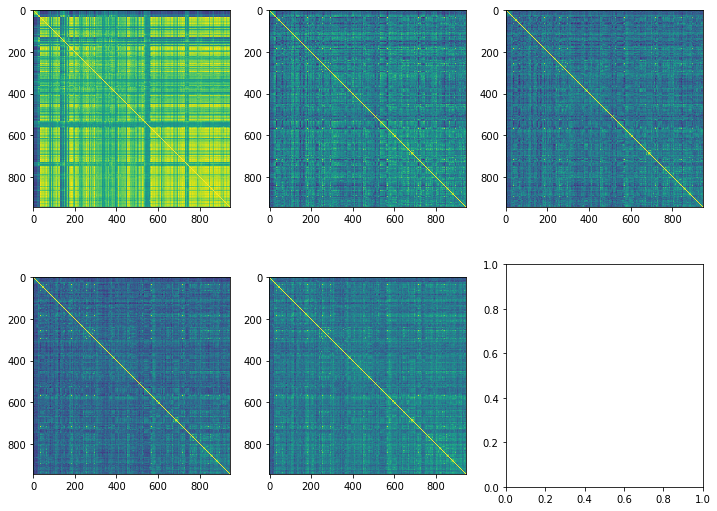

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 9))
ax[0, 0].imshow(c1)
ax[0, 1].imshow(c4)
ax[0, 2].imshow(c7)
ax[1, 0].imshow(c9)
ax[1, 1].imshow(c11)